In [3]:
import os
import glob
from functools import reduce

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

## Configurations

```json
{
    "vms": {
        "base_vm_id": 105,
        "clients": [110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125],
        "type-unused": "NAT",
        "type": {
            "DR": {
                "prefix": "172.17.60.0/24",
                "iface": "eth1"
            }
        }
    },
    "httperf": {
        "vip": "172.17.60.201",
        "port": 80,
        "num-conns": 2000,
        "num-calls": 1,
        "rate": 20,
        "ramp": 20,
        "iters": 50,
        "timeout": 1
    }
}
```

In [5]:
run_name = "current/httperf_unbalance_wlc_to1_fdb_percentiles"

## Client side stats

In [6]:
# read in the data
plot_data_list = []

for i in glob.glob("./results/" + run_name + "/httperf_client_*.csv"):
    plot_data_list.append(pd.read_csv(i, header=0, na_filter=False))

In [7]:
plot_data = pd.DataFrame()

if len(plot_data_list) > 0:
    for i in list(plot_data_list[0]):
        plot_data[i] = reduce(lambda x, y: x + y, [plot_data_list[j][i] for j in range(len(plot_data_list))])

    plot_data['Response time'] = reduce(lambda x, y: x + y, [plot_data_list[j]['Response time'] 
                                                             for j in range(len(plot_data_list))]) / len(plot_data_list)

plot_data.head()

,Response time 66%,Response status 4xx,Response rate 99%,Response time 50%,Response time 99%,Response rate 66%,Response rate 75%,Response time,Number of requests,Response rate 90%,...,Response rate 98%,Response time 98%,Request rate,Response time 90%,Response status 5xx,Response status 2xx,Response time 80%,Response rate 50%,Rate,Response rate 95%
0,23.0,0,335.0,16.0,2335.0,304.0,304.0,8.68125,32000,318.0,...,326.0,1329.0,320.0,292.0,0,31978,85.0,304.0,320,320.0
1,27.0,0,750.0,16.0,14700.0,656.0,669.0,81.97500,31985,707.0,...,750.0,13591.0,639.8,5136.0,0,31704,658.0,626.0,640,722.0
2,38.0,0,998.0,16.0,14115.0,884.0,924.0,30.28750,31099,956.0,...,998.0,9758.0,928.2,129.0,0,28715,71.0,833.0,960,975.0
3,62.0,0,1330.0,32.0,12602.0,1249.0,1262.0,28.22500,31702,1286.0,...,1330.0,8836.0,1255.0,141.0,0,30422,95.0,1214.0,1280,1297.0
4,69.0,0,1678.0,46.0,7585.0,1587.0,1597.0,18.20625,32000,1637.0,...,1678.0,4736.0,1599.4,160.0,0,31664,109.0,1579.0,1600,1669.0


### 1. Request rate

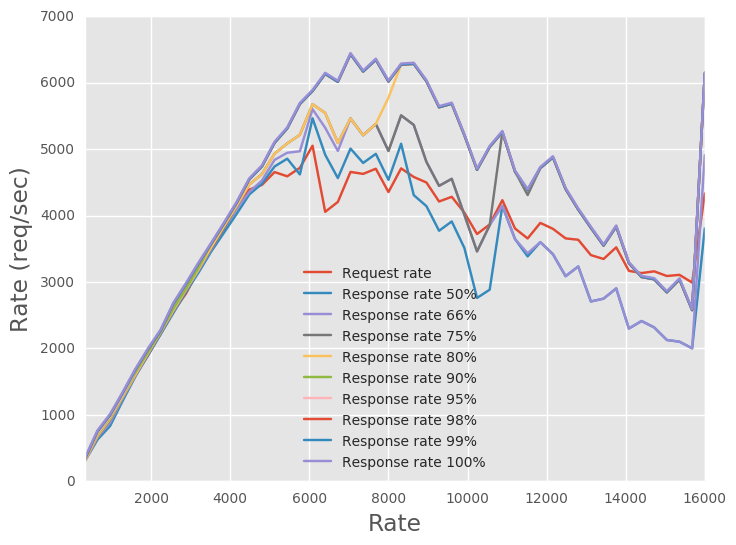

In [8]:
plot_data.plot('Rate', ['Request rate', 'Response rate 50%', 'Response rate 66%', 'Response rate 75%',
                        'Response rate 80%', 'Response rate 90%', 'Response rate 95%', 'Response rate 98%',
                        'Response rate 99%', 'Response rate 100%'], ylim=(0, None)).set_ylabel("Rate (req/sec)")

In [9]:
plot_data['Rate'].describe()

count       50.000000
mean      8160.000000
std       4664.761516
min        320.000000
25%       4240.000000
50%       8160.000000
75%      12080.000000
max      16000.000000
Name: Rate, dtype: float64

In [10]:
plot_data['Request rate'].describe()

count      50.000000
mean     3543.880000
std      1117.137062
min       320.000000
25%      3141.600000
50%      3803.700000
75%      4349.000000
max      5052.100000
Name: Request rate, dtype: float64

In [11]:
plot_data['Response rate 95%'].describe()

count      50.000000
mean     4212.220000
std      1638.087639
min       320.000000
25%      3050.750000
50%      4473.500000
75%      5668.500000
max      6431.000000
Name: Response rate 95%, dtype: float64

### 2. Response time

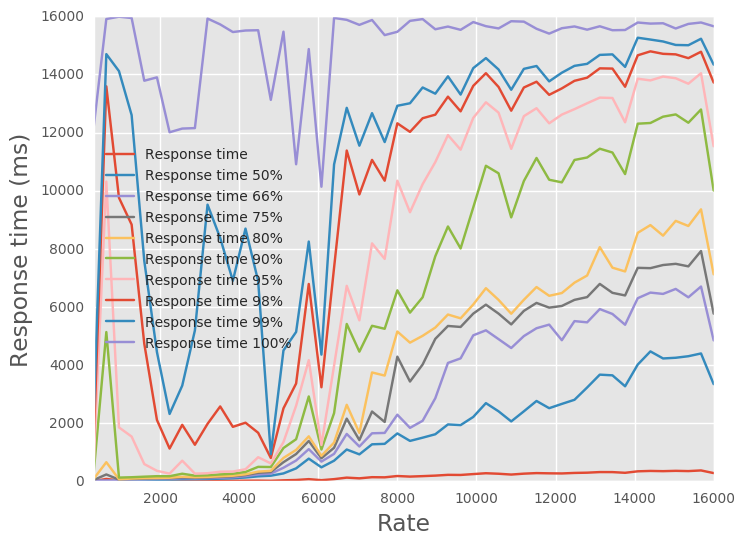

In [12]:
plot_data.plot('Rate', ['Response time', 'Response time 50%', 'Response time 66%', 'Response time 75%',
                        'Response time 80%', 'Response time 90%', 'Response time 95%', 'Response time 98%',
                        'Response time 99%', 'Response time 100%'], ylim=(0, None)).set_ylabel("Response time (ms)")

In [13]:
plot_data['Response time'].describe()

count     50.000000
mean     166.766750
std      127.788659
min        8.681250
25%       28.740625
50%      170.962500
75%      282.131250
max      374.856250
Name: Response time, dtype: float64

In [14]:
plot_data['Response time 95%'].describe()

count       50.000000
mean      7683.740000
std       5477.853798
min        265.000000
25%       1274.250000
50%      10269.500000
75%      12669.250000
max      14042.000000
Name: Response time 95%, dtype: float64

### 3. Success rate

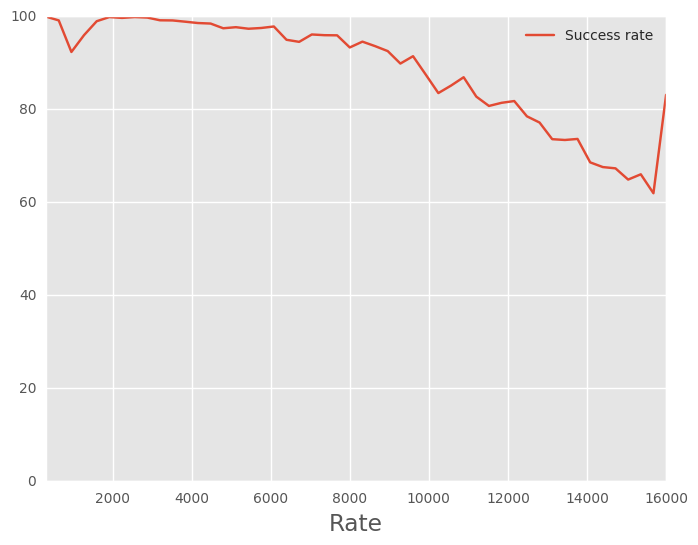

In [15]:
plot_data['Success rate'] = (plot_data['Response status 2xx'] + plot_data['Response status 3xx']) / plot_data['Number of requests'] * 100.0
plot_data.plot('Rate', 'Success rate', ylim=(0, None))

In [16]:
plot_data['Success rate'].describe()

count    50.000000
mean     88.506391
std      11.464319
min      61.954262
25%      81.498133
50%      93.450106
75%      97.777604
max      99.931250
Name: Success rate, dtype: float64

## Server side stats

In [18]:
# read in the stats data
stats_data = pd.read_csv("./results/" + run_name + "/httperf_server_stats.csv", header=0, na_filter=False)
stats_data['Connections Ratio (%)'] = stats_data['Connections'] / sum(stats_data['Connections']) * 100
stats_data['Packets Ratio (%)'] = stats_data['Packets'] / sum(stats_data['Packets']) * 100
stats_data['Bytes Ratio (%)'] = stats_data['Bytes (K)'] / sum(stats_data['Bytes (K)']) * 100
stats_data

,Connections,Packets,Bytes (K),Connections Ratio (%),Packets Ratio (%),Bytes Ratio (%)
11.11.11.107:80,6731,386084,25439.942,11.006819,5.923861,5.852474
11.11.11.106:80,19525,2168086,144888.000,31.928115,33.265919,33.331574
11.11.11.103:80,17376,1998357,133322.000,28.413978,30.661691,30.670809
11.11.11.102:80,17521,1964912,131037.000,28.651088,30.148529,30.145143
